## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import legacy
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

## Import Dataset

In [2]:
!unzip -t dataset.zip

Archive:  dataset.zip
    testing: dataset/no/              OK
    testing: dataset/no/1 no.jpeg     OK
    testing: dataset/no/10 no.jpg     OK
    testing: dataset/no/11 no.jpg     OK
    testing: dataset/no/12 no.jpg     OK
    testing: dataset/no/13 no.jpg     OK
    testing: dataset/no/14 no.jpg     OK
    testing: dataset/no/15 no.jpg     OK
    testing: dataset/no/17 no.jpg     OK
    testing: dataset/no/18 no.jpg     OK
    testing: dataset/no/19 no.jpg     OK
    testing: dataset/no/2 no.jpeg     OK
    testing: dataset/no/20 no.jpg     OK
    testing: dataset/no/21 no.jpg     OK
    testing: dataset/no/22 no.jpg     OK
    testing: dataset/no/23 no.jpg     OK
    testing: dataset/no/24 no.jpg     OK
    testing: dataset/no/25 no.jpg     OK
    testing: dataset/no/26 no.jpg     OK
    testing: dataset/no/27 no.jpg     OK
    testing: dataset/no/28 no.jpg     OK
    testing: dataset/no/29 no.jpg     OK
    testing: dataset/no/3 no.jpg      OK
    testing: dataset/no/30 no.jpg  

In [3]:
import zipfile

z = zipfile.ZipFile('dataset.zip')

z.extractall()

In [4]:
import zipfile

z = zipfile.ZipFile('augmented_data.zip')

z.extractall()

# 1) Data Preparation

In [5]:
folder = 'dataset/yes/'
count= 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files have been renamed in the yes dir.")

All files have been renamed in the yes dir.


In [6]:
folder = 'dataset/no/'
count= 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files have been renamed in the no dir.")

All files have been renamed in the no dir.


# 2) Exploratory Data Analysis

In [7]:
listyes = os.listdir("dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


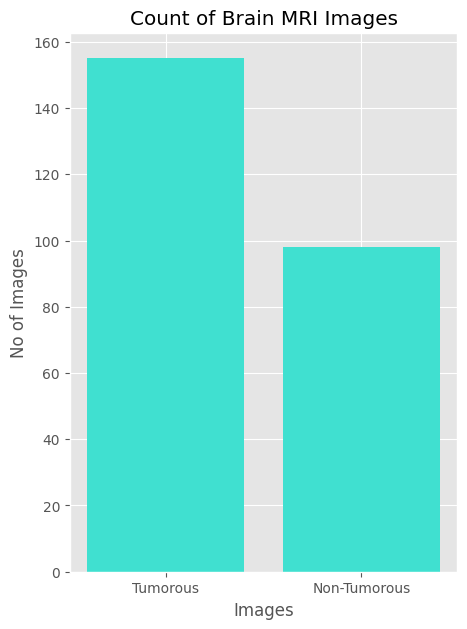

In [8]:
data = {'Tumorous': number_files_yes, 'Non-Tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="turquoise")

plt.xlabel("Images")
plt.ylabel("No of Images")
plt.title("Count of Brain MRI Images")
plt.show()

# 3) Data Augmentation

## Import Libraries

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [10]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [11]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [12]:
import time
start_time = time.time()

yes_path = 'dataset/yes'
no_path = 'dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:32.78447675704956


In [13]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of samples: {n}")
    print(f"Number of positive samples: {n_pos}")
    print(f"Number of negative samples: {n_neg}")
    print(f"Number of positive samples in percentage: {pos_per} %")
    print(f"Number of negative samples in percentage: {neg_per} %")

In [14]:
data_summary(augmented_data_path)

Number of samples: 2064
Number of positive samples: 1085
Number of negative samples: 979
Number of positive samples in percentage: 52.56782945736434 %
Number of negative samples in percentage: 47.43217054263566 %


In [15]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1085
979


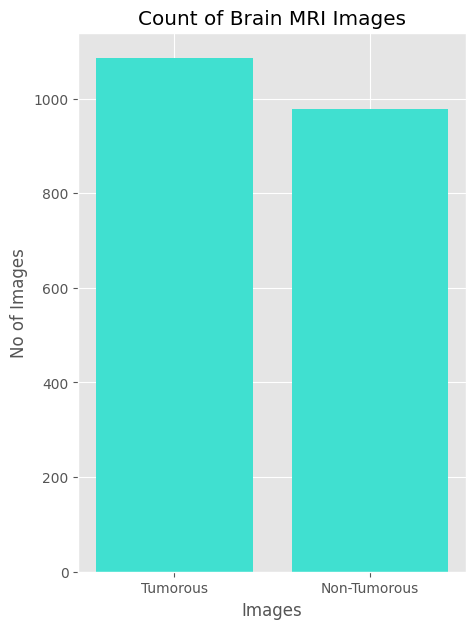

In [16]:
data = {'Tumorous': number_files_yes, 'Non-Tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="turquoise")

plt.xlabel("Images")
plt.ylabel("No of Images")
plt.title("Count of Brain MRI Images")
plt.show()

# 4) Data Preprocessing

In [17]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

In [18]:
# Manually copy and paste any image from the "yes" folder in the "augmented_data" folder
#mg = cv2.imread('augmented_data/yes/aug_Y_101_0_7912.jpg')
#crop_brain_tumor(img, True)

In [19]:
# Manually copy and paste any image from the "no" folder in the "augmented_data" folder
#img = cv2.imread('augmented_data/no/aug_N_12_0_6831.jpg')
#crop_brain_tumor(img, True)

In [20]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

## Image Loading

In [21]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of examples are : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [22]:
augmented_path = 'augmented_data/'
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of examples are : 2064
X SHAPE is : (2064, 240, 240, 3)
y SHAPE is : (2064,)


In [23]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

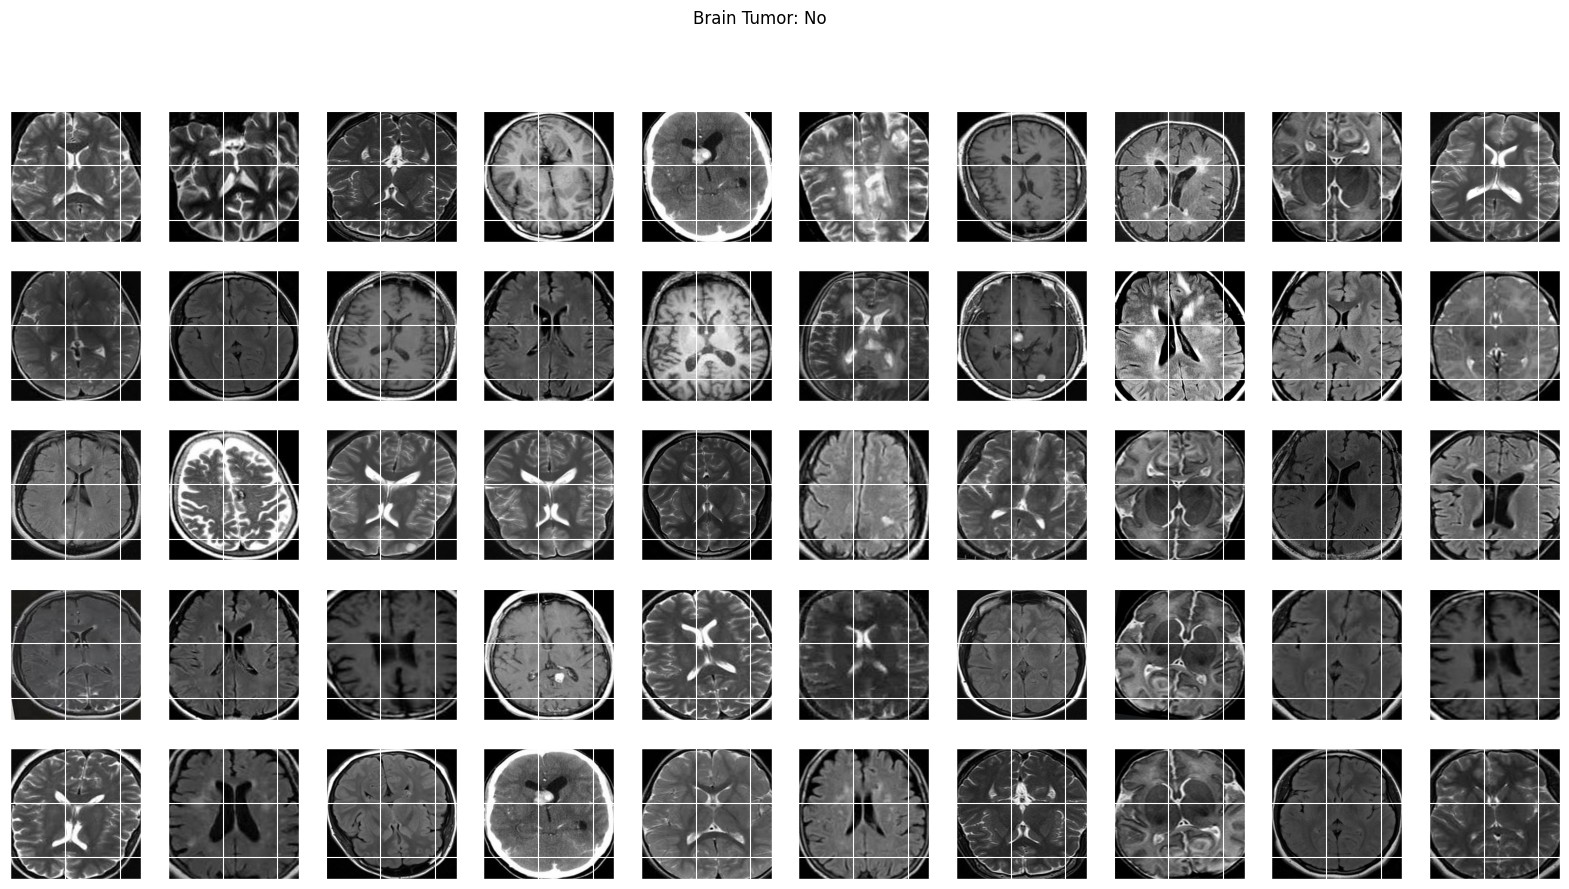

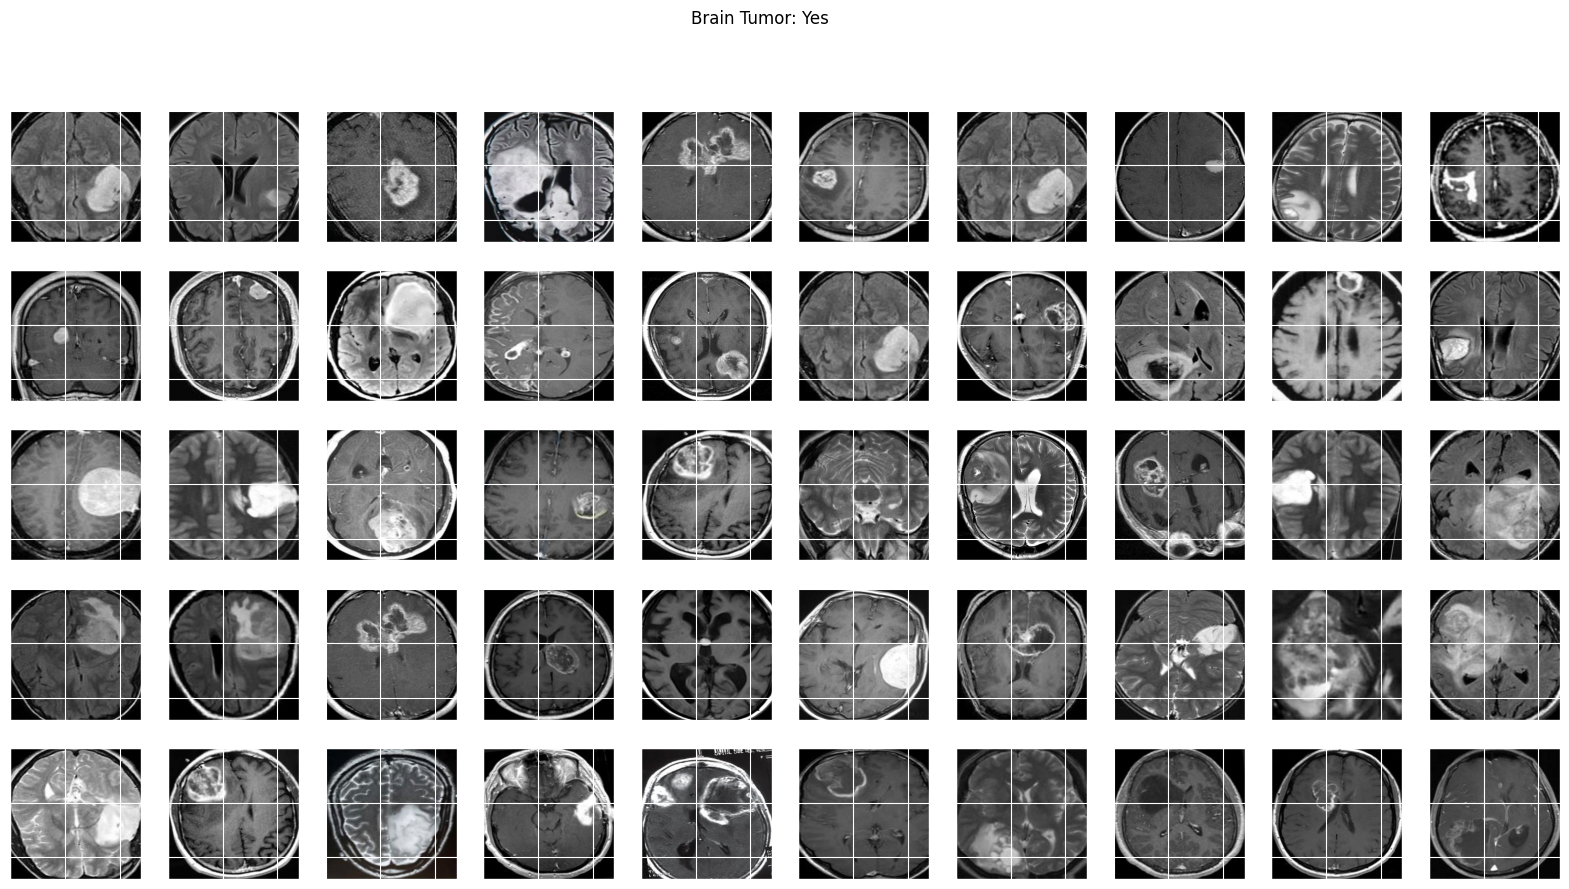

In [24]:
plot_sample_images(X,y)

# 5) Data Splitting


In [25]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [26]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [27]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [28]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [29]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [30]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [31]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [32]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922,len(files)):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [33]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [34]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [35]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833,len(files)):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

# 6) Model Building

In [36]:
train_datagen = ImageDataGenerator (rescale = 1./255,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=0.1/255)
valid_data_gen = ImageDataGenerator (rescale=1.0/255)

In [37]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/',batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode = 'rgb')

Found 1445 images belonging to 2 classes.


In [38]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/',batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode = 'rgb')

Found 310 images belonging to 2 classes.


In [39]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/',batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode = 'rgb')

Found 309 images belonging to 2 classes.


In [40]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [41]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [42]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)
model_01 = Model(base_model. input, output)
model_01. summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                              

## Callback

In [43]:
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode = 'min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False,mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

In [44]:
sgd = legacy.SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy',optimizer = sgd, metrics=['accuracy'])

In [46]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs=40,callbacks=[es,cp,lrr],validation_data=valid_generator)

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.5031
Epoch 1: val_loss did not improve from 0.69892
10/10 [==============================] - 12s 1s/step - loss: 0.7201 - accuracy: 0.5031 - val_loss: 0.7143 - val_accuracy: 0.5146 - lr: 1.0000e-04
Epoch 2/40
10/10 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5719
Epoch 2: val_loss improved from 0.69892 to 0.64864, saving model to model.h5
10/10 [==============================] - 20s 2s/step - loss: 0.6896 - accuracy: 0.5719 - val_loss: 0.6486 - val_accuracy: 0.6149 - lr: 1.0000e-04
Epoch 3/40
10/10 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5836
Epoch 3: val_loss improved from 0.64864 to 0.64355, saving model to model.h5
10/10 [==============================] - 22s 2s/step - loss: 0.6875 - accuracy: 0.5836 - val_loss: 0.6436 - val_accuracy: 0.6343 - lr: 1.0000e-04
Epoch 4/40
10/10 [==============================] - ETA: 0s - loss: 0.6611 - ac

## Plot Performance


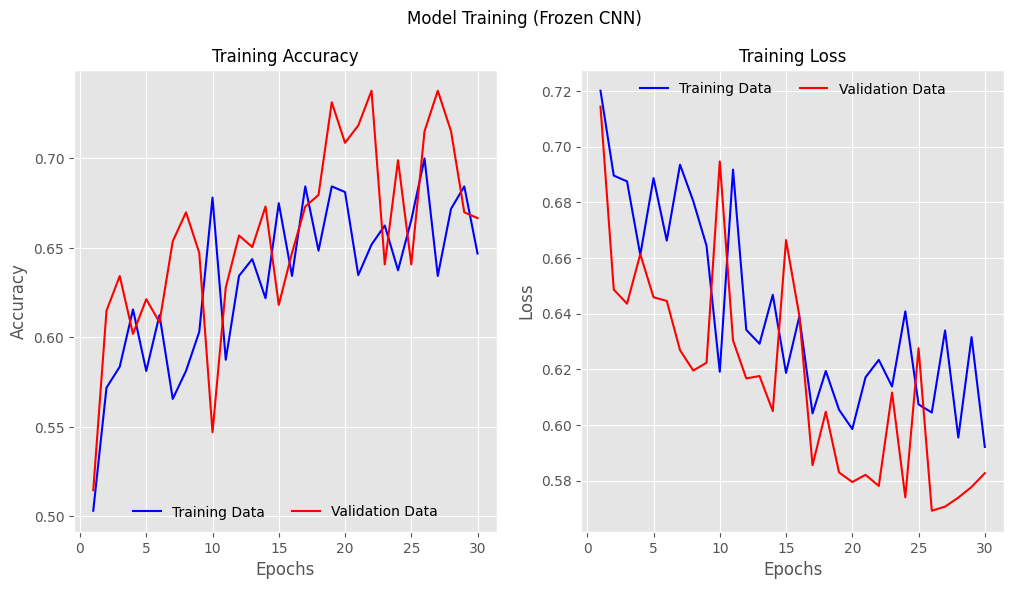

In [47]:
fig, (ax1, ax2) = plt.subplots (nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch= len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend (frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle= '-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle= '-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend (frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [48]:
if not os.path.isdir ('model_weights/'):
  os.mkdir('model_weights/')
model_01.save_weights (filepath="model_weights/vgg19_model_01.h5", overwrite=True)

In [49]:
model_01.load_weights("model_weights/vgg19_model_01.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 [==============================] - 11s 1s/step - loss: 0.5947 - accuracy: 0.6387


In [50]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print (f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print (f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6001681685447693
Validation Acc: 0.6310679316520691
Testing Loss: 0.5947368741035461
Testing Acc: 0.6387096643447876


In [51]:
filenames = test_generator.filenames
nb_sample= len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose= 1)
y_pred= np.argmax(vgg_prediction_01, axis=1)

 10/310 [..............................] - ETA: 2:28

310/310 [==============================] - 5s 15ms/step


# 7) Unfreezing and Fine Tuning

In [52]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [53]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [54]:
sgd= legacy.SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [59]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=40,callbacks=[es,cp,lrr],validation_data=valid_generator)

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 0.5669 - accuracy: 0.7031
Epoch 1: val_loss did not improve from 0.54214
10/10 [==============================] - 12s 1s/step - loss: 0.5669 - accuracy: 0.7031 - val_loss: 0.5477 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 2/40
10/10 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7188
Epoch 2: val_loss improved from 0.54214 to 0.54095, saving model to model.h5
10/10 [==============================] - 68s 8s/step - loss: 0.5579 - accuracy: 0.7188 - val_loss: 0.5410 - val_accuracy: 0.7443 - lr: 1.0000e-04
Epoch 3/40
10/10 [==============================] - ETA: 0s - loss: 0.5596 - accuracy: 0.7094
Epoch 3: val_loss improved from 0.54095 to 0.53503, saving model to model.h5
10/10 [==============================] - 55s 6s/step - loss: 0.5596 - accuracy: 0.7094 - val_loss: 0.5350 - val_accuracy: 0.7411 - lr: 1.0000e-04
Epoch 4/40
10/10 [==============================] - ETA: 0s - loss: 0.5771 - ac

## Plot Performance

ValueError: x and y must have same first dimension, but have shapes (30,) and (10,)

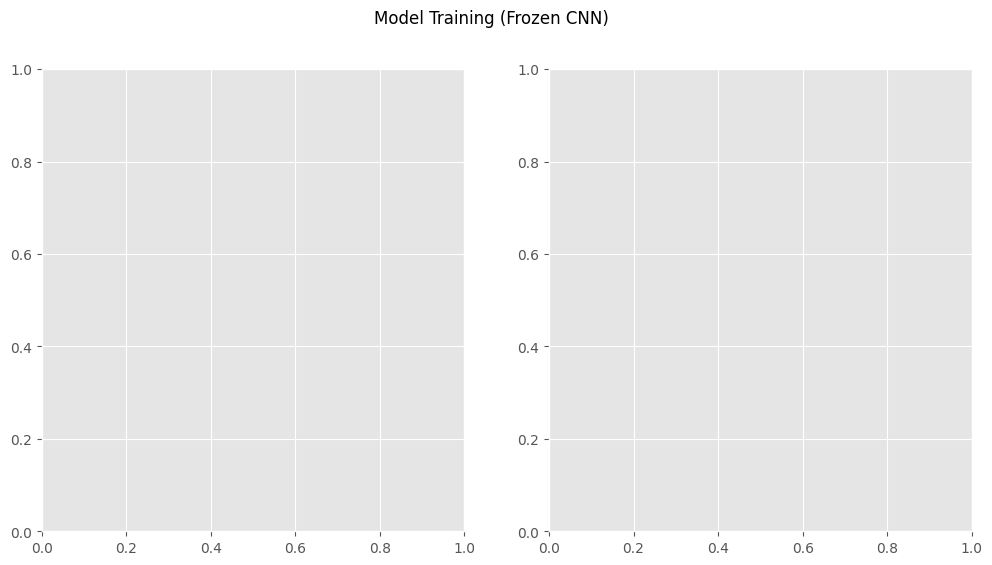

In [60]:
fig, (ax1, ax2) = plt.subplots (nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch= len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend (frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle= '-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle= '-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend (frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [61]:
if not os.path.isdir ('model_weights/'):
  os.mkdir('model_weights/')
model_02.save_weights (filepath="model_weights/vgg19_model_02.h5", overwrite=True)

In [62]:
model_02.load_weights("model_weights/vgg19_model_02.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

10/10 [==============================] - 5s 461ms/step - loss: 0.5468 - accuracy: 0.7323


In [63]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd= SGD(learning_rate=0.0001, weight_decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [64]:
model_03.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [66]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs=40,callbacks=[es,cp,lrr],validation_data=valid_generator)

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.7906
Epoch 1: val_loss did not improve from 0.48413
10/10 [==============================] - 14s 1s/step - loss: 0.4841 - accuracy: 0.7906 - val_loss: 0.5065 - val_accuracy: 0.7476 - lr: 1.0000e-04
Epoch 2/40
10/10 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.7312
Epoch 2: val_loss did not improve from 0.48413
10/10 [==============================] - 14s 1s/step - loss: 0.4835 - accuracy: 0.7312 - val_loss: 0.5271 - val_accuracy: 0.7767 - lr: 1.0000e-04
Epoch 3/40
10/10 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.7782
Epoch 3: val_loss did not improve from 0.48413
10/10 [==============================] - 22s 2s/step - loss: 0.5238 - accuracy: 0.7782 - val_loss: 0.5109 - val_accuracy: 0.7702 - lr: 1.0000e-04
Epoch 4/40
10/10 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.7918
Epoch 4: val_loss improved from 0.48413 to 0.

In [67]:
model_03.load_weights("model_weights/vgg19_model_02.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 [==============================] - 5s 453ms/step - loss: 0.5613 - accuracy: 0.6806
